Erreur du code :

  - inversion des states, dans le code : [a, t, t-1, t+1]
  - oubli dans le reset de prendre en compte le state classique
  - recuperation des variables avant de reset le setpoint

## Import

In [1]:
!pip install gymnasium --quiet
!pip install ray[rllib] --quiet

In [2]:
import gymnasium as gym
import numpy as np
import scipy.ndimage as sm
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch
import ray
from ray.rllib.algorithms import dqn
from ray.tune.registry import register_env
from ray.rllib.algorithms.algorithm import Algorithm
from ray import tune
import pandas as pd
import csv

/usr/local/lib/python3.10/dist-packages/flax/configurations.py:42: DeprecationWarning: jax.config.define_bool_state is deprecated. Please use other libraries for configuration instead.
  return jax_config.define_bool_state('flax_' + name, default, help)
/usr/local/lib/python3.10/dist-packages/flax/linen/activation.py:36: DeprecationWarning: jax.nn.normalize is deprecated. Use jax.nn.standardize instead.
  from jax.nn import normalize
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [3]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Environment

In [4]:
# Classe principale de l'env avec consigne
class SetpointWrapper(gym.Wrapper):
    def __init__(self,
                 config = {
                     "env":None,
                     "mode":0,
                     "classic":False,
                     "dim":None}):
      self.env = gym.make(config["env"])
      super().__init__(self.env)
      #assert config["mode"] in range(4), "il existe seulement 3 modes : 0, 1 et 2"
      #assert dim in [None,range(env.observation_space.shape[0])], "il existe "+env.observation_space.shape[0]+" dimensions"

      self._max_episode_steps=self.env._max_episode_steps
      self.mode = config["mode"]  # Mode de l'env
      self.taux_r = 0
      self._elapsed_steps = 0
      self.choice_state(config["dim"])  # Fonction choix de variable + definition du min-max
      self.set_setpoint()  # Fonction choix de la consigne en fonction du mode
      self.classic = config['classic']

      self.SPRL = None

      self.previous_state = None  # Memoire state
      self.previous_action = None # Memoire action

      # Modification de l'espace d'observation
      if self.classic : self.observation_space = self.observation_space = gym.spaces.Box(low=np.array([-np.inf, self.env.observation_space.low[1], self.env.observation_space.low[2], self.env.observation_space.low[3]], dtype=np.float32), high=np.array([np.inf, self.env.observation_space.high[1], self.env.observation_space.high[2], self.env.observation_space.high[3]], dtype=np.float32)) #a modifier
      else : self.observation_space = gym.spaces.Box(low=np.array([0., self.setmin_base, self.setmin_base, self.setmin_base], dtype=np.float32), high=np.array([1., self.setmax_base, self.setmax_base, self.setmax_base], dtype=np.float32))
      self.action_space = self.env.action_space #gym.spaces.Discrete(2)  # Modification de l'espace d'action

    def choice_state(self, dimension=None):
      state_box = self.env.observation_space
      # possible dimension (E fini)
      if dimension is None:
          dim = np.where((state_box.high - state_box.low) != np.inf)[0]
          self.chosen_state = np.random.choice(dim)
          print(self.chosen_state)
      else :
          self.chosen_state = dimension
      # boundary
      self.setmin_base = state_box.low[self.chosen_state] # Limite observation
      self.setmin = state_box.low[self.chosen_state]/2 # Division afin d'être dans les même conditions que le mode non personalisé
      self.setmax_base = state_box.high[self.chosen_state]
      self.setmax = state_box.high[self.chosen_state]/2
      if self.mode>-1:
        self.taux_r = 0.1*(self.setmax-self.setmin)
        self.setmax-= self.taux_r
        self.setmin+= self.taux_r

    # Génération du signal d'entrée (consigne) aléatoire
    def signal_generator(self, N, epsilon=0.05):
        a = (1 - 2*epsilon)
        # smoother
        s = np.random.randint(1,N//10)
        # random
        r = np.random.random(N)
        # smooth signal
        smooth = sm.gaussian_filter1d(r, s)
        n = a*(smooth - smooth.min())/(smooth.max() - smooth.min()) + epsilon
        return n

    def set_setpoint(self, epsilon=0.05):
        # modes
        if self.mode < 1  :
            self.setpoint = 0
        elif self.mode == 1 :
            self.setpoint = np.random.uniform(self.setmin, self.setmax)
        else :
            consigne = self.signal_generator(self._max_episode_steps+5, epsilon=0.05) # def pour nb max iter
            self.all_setpoint = (self.setmax - self.setmin)*consigne + self.setmin # rescale de  0-1 vers valeurs cibles
            self.setpoint = self.all_setpoint[1]

    # Fonction qui retourne le bon format d'observation
    def obs_mode(self, state, init=False):
      # classic, Constant or setpoint
      if self.mode == 2 :
        self.setpoint = self.all_setpoint[self._elapsed_steps+1]
      if init :
        self.previous_state = state[self.chosen_state]
        self.previous_action = self.action_space.sample()
      obs = np.array([self.previous_action, state[self.chosen_state], self.previous_state, self.setpoint])
      self.previous_state = state[self.chosen_state]
      return obs

    # Fonction reset
    def reset(self, seed=None, options=None):
      state, _ = self.env.reset()
      self._elapsed_steps = 0 # reset steps
      self.set_setpoint() # reset setpoint
      # classic or SPRL
      self.SPRL = self.obs_mode(state, init=True)
      if self.classic: obs = state
      else : obs = self.SPRL
      return obs, {}

    # Fonction step avec gestion des arrets d'episode
    def step(self, action):
      self._elapsed_steps+=1
      state, _, _, truncated, info = self.env.step(action)
      # classic or SPRL
      self.SPRL = self.obs_mode(state)
      if self.classic: obs = state
      else : obs = self.SPRL
      self.previous_action = action
      # si mode -1 alors classique sinon gestion
      pos_pole = state[2]
      #gestion du terminated
      if self.mode>-1 :
        terminated = (pos_pole < self.setmin-self.taux_r or pos_pole > self.setmax+self.taux_r)
        if self.setpoint-self.taux_r>pos_pole or pos_pole>self.setpoint+self.taux_r:
          reward=0.1
        else : reward=1.
      else :
        terminated = (pos_pole < self.setmin or pos_pole > self.setmax)
        if not terminated : reward = 1
        else : reward = 0
      return obs, reward, terminated, truncated, info

## Checkpoint

In [5]:
ray.shutdown()
ray.init()

2024-01-27 17:20:01,575	INFO worker.py:1724 -- Started a local Ray instance.


Python version:,3.10.12
Ray version:,2.9.1


In [6]:
dirpath = "/content/drive/MyDrive/Colab Notebooks/SetpointReinforcementLearning/checkpoints/"
rpath = "/content/drive/MyDrive/Colab Notebooks/SetpointReinforcementLearning/results/"

In [7]:
## agent name
agent_n1_classique = "modele_-1_classique"
agent_n1 = "modele_-1"
agent_0_classique = "modele_0_classique"
agent_0 = "modele_0"
agent_1 = "modele_1"
agent_2 = "modele_2"
## agent config environnement --> test on mode 2
setconfig_n1_classique = {"env":"CartPole-v1", "mode":-1,"classic":True,"dim":2}
setconfig_n1 = {"env":"CartPole-v1", "mode":-1,"classic":False,"dim":2}
setconfig_0_classique = {"env":"CartPole-v1", "mode":0,"classic":True,"dim":2}
setconfig_0 = {"env":"CartPole-v1", "mode":0,"classic":False,"dim":2}
setconfig_1 = {"env":"CartPole-v1", "mode":1,"classic":False,"dim":2}
setconfig_2 = {"env":"CartPole-v1", "mode":2,"classic":False,"dim":2}

In [8]:
## udate environment & agent
def update_model(setconfig, checkpoint_path, mode=None):
  register_env("custom_env", lambda config: SetpointWrapper(setconfig))
  # Agent Algo
  agent = Algorithm.from_checkpoint(checkpoint_path)
  # Environment
  if mode != None : setconfig["mode"] = mode
  env = SetpointWrapper(setconfig)
  return env, agent

### Unit test

In [9]:
# test
#path = dirpath + "checkpoint_" + agent_n1_classique
path = dirpath + "checkpoint_" + agent_2
#env, agent = update_model(setconfig_n1_classique, path, mode=2)
env, agent = update_model(setconfig_2, path, mode=2)

2024-01-27 17:20:04,243	WARNING deprecation.py:50 -- DeprecationWarning: `rllib/algorithms/simple_q/` has been deprecated. Use `rllib_contrib/simple_q/` instead. This will raise an error in the future!
/usr/local/lib/python3.10/dist-packages/ray/rllib/algorithms/algorithm.py:483: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/usr/local/lib/python3.10/dist-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


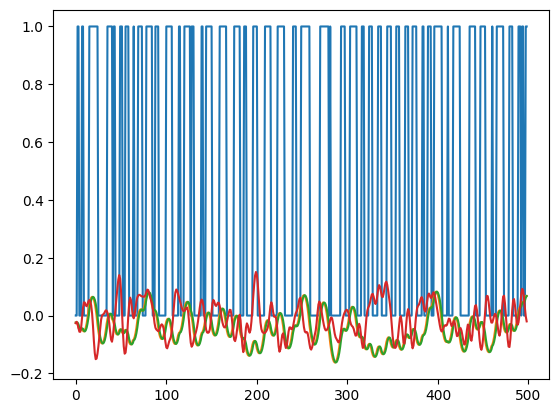

In [10]:
# simulation
s, sprl = [], []
for j in range(1):
  state, _ = env.reset()
  sprl += [[env.SPRL]]
  s += [[state]]
  for i in range(env._max_episode_steps-2) :
    action = agent.compute_single_action(state)
    state, reward, done, _, info = env.step(action)
    s += [[state]]
    sprl += [[env.SPRL]]
    if done: break
s = np.concatenate(s)
sprl = np.concatenate(sprl)
plt.plot(sprl); plt.show()

## Test all model

In [11]:
agents = [agent_n1_classique, agent_n1, agent_0_classique, agent_0, agent_1, agent_2]
setconfigs = [setconfig_n1_classique, setconfig_n1, setconfig_0_classique, setconfig_0, setconfig_1, setconfig_2]

In [12]:
columns = ["train","tested_on","episode","time","action-1","state-1","state","state_c","action","reward"]
data = []
for a,c in tqdm(zip(agents,setconfigs), total=len(agents)) :
  # test on
  for m in tqdm(range(3)):
    # import model and set env
    path = dirpath + "checkpoint_" + a
    env, agent = update_model(c, path, mode=m)
    # 100 simulation (episode)
    for e in tqdm(range(100)):
      state, _ = env.reset()
      # loop
      for i in range(env._max_episode_steps-2) :
        action = agent.compute_single_action(state)
        state, reward, done, _, info = env.step(action)
        # extract data
        data += [[a,m,e,i] + list(env.SPRL) + [action, reward]]
        if done: break
# save dataframe
df = pd.DataFrame(data, columns=columns)
df.to_csv(rpath + "test_mode_cartpole.csv")

  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ray/rllib/algorithms/algorithm.py:483: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/usr/local/lib/python3.10/dist-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/usr/local/lib/python3.10/dist-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in 

In [ ]:
df.sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
